In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import scipy
import pandas as pd
import pdb
from tqdm import tqdm
import pickle
import sys
from matplotlib import pyplot as plt
import h5py

In [3]:
import sys

In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [5]:
from loaders import load_sabes_wf, load_sabes
from utils import apply_df_filters, calc_loadings

In [81]:
#data_files = glob.glob('/mnt/sdb1/nc_data/sabes/*.mat')    
data_files = glob.glob('/mnt/Secondary/data/sabes/*.mat')

In [7]:
cell = wf[4]
spikes = []
for j, spike in enumerate(cell):
    # Upsample the spike
    t1 = np.arange(len(spike))
    t2 = np.linspace(0, t1[-1], t1.size * 50)
    # Normalize
    spike /= np.max(np.abs(spike))
    sinterp = scipy.interpolate.CubicSpline(t1, spike)
    spike_ = sinterp(t2)
    spikes.append(spike_)

# We want to exclude neurons that do not have a peak following the trough        
spike = np.mean(spikes, axis=0)

NameError: name 'wf' is not defined

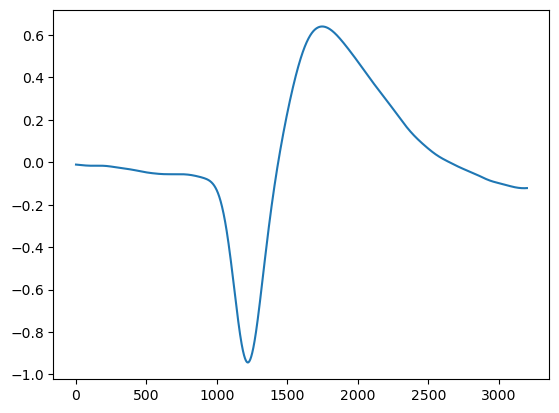

In [34]:
plt.plot(spike)

100%|██████████| 7/7 [00:49<00:00,  7.08s/it]


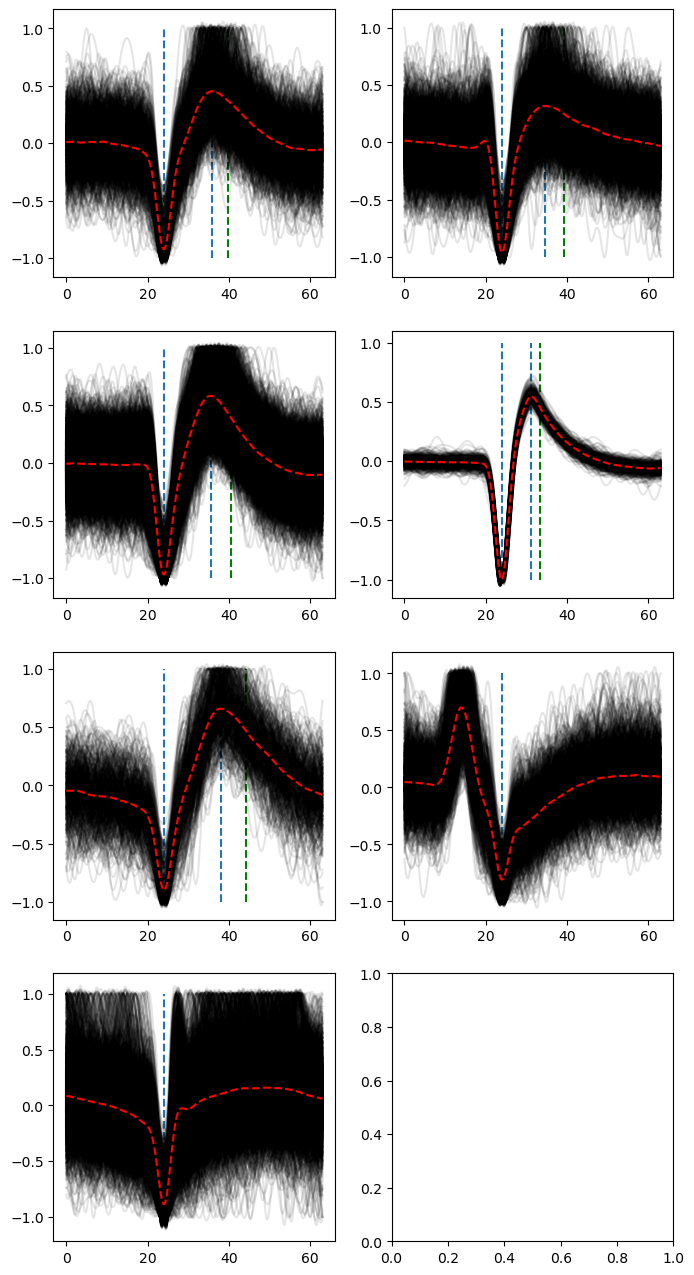

In [86]:
# In Kaufman, Shenoy, the waveforms are averaged prior to classifying waveform statistics. Let's co-plot all the spikes from a few neurons to assess how repeatable shape is, 
# and whether additional rejection criteria are required

# Note the discussion at the end of the paper: Results will generally be cleaner with single electrodes than multiarrays. However, the latter is now canonical, and the 
# current biology article uses tungsten microelectrodes

wf = load_sabes_wf(data_files[0])

fig, ax = plt.subplots(4, 2, figsize=(8, 16))

random = np.random.RandomState(12)
idxs = random.choice(np.arange(len(wf)), 25)

# Pick out some illustrative examples
idxs = [idxs[0], idxs[1], idxs[2], idxs[4], idxs[17], idxs[7], idxs[11]]


for i in tqdm(range(7)):
    a = ax[np.unravel_index(i, (4, 2))]
    cell = wf[idxs[i]]
    spikes = []
    for j, spike in enumerate(cell):
        # Upsample the spike
        t1 = np.arange(len(spike))
        t2 = np.linspace(0, t1[-1], t1.size * 50)
        # Normalize
        spike /= np.max(np.abs(spike))
        sinterp = scipy.interpolate.CubicSpline(t1, spike)
        spike_ = sinterp(t2)
        a.plot(t2, spike_, color='k', alpha=0.1)
        spikes.append(spike_)

    # We want to exclude neurons that do not have a peak following the trough        
    spike = np.mean(spikes, axis=0)

    # Global minima
    gmin = np.argmin(spike)

    # local maxima
    pks = scipy.signal.find_peaks(spike, height=0, prominence=0.2)[0]

    # After the minimum
    pks = pks[pks > gmin]

    # But before too long...
    pks = pks[t2[pks] - t2[gmin] < 25]

    # Plot vertical line where the global minimum is identified
    a.vlines(t2[gmin], -1, 1, linestyles='dashed')
    if len(pks) > 0:
        a.vlines(t2[pks[0]], -1, 1, linestyles='dashed')

        # Using the averaged traces, the post peak inflection point may be measurable
        # Use just the first derivative to reduce numerical noise
        ds = np.diff(spike)
        ds = np.abs(ds)/np.max(np.abs(ds))
        
        dpks = scipy.signal.find_peaks(np.abs(ds)/np.max(np.abs(ds)), height=0.05)[0]
        if len(dpks > 0):
            dpks = dpks[dpks > pks[0]]
        if len(dpks) > 0:
            a.vlines(t2[dpks[0]], -1, 1, color='green', linestyles='dashed')


    a.plot(t2, spike, color='r', linestyle='--')
    #fig.delaxes(ax[3, 1])
    fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/spike_examples.pdf', bbox_inches='tight', pad_inches=0)

In [61]:
scipy.signal.find_peaks(np.abs(d2)/np.max(np.abs(d2)), height=0.05)

(array([1141, 1311, 1795, 2072, 2288]),
 {'peak_heights': array([0.70265706, 1.        , 0.20602255, 0.1213939 , 0.05394155])})

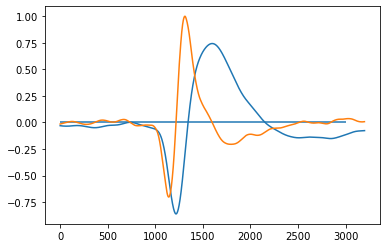

In [55]:
plt.plot(spike)
#d2 = np.diff(np.diff(spike))
d2 = np.diff(spike)
plt.plot(d2/np.max(np.abs(d2)))
plt.hlines(0, 0, 3000)
#plt.ylim([-0.1, 0.1])

In [8]:
# Extract the spike width and hyperpolarization
def extract_wf_features(spikes):

    spikes_pp = []
    for spike in spikes:
        t1 = np.arange(len(spike))
        t2 = np.linspace(0, t1[-1], t1.size * 50)
        # Normalize
        spike /= np.max(np.abs(spike))
        sinterp = scipy.interpolate.CubicSpline(t1, spike)
        spike_ = sinterp(t2)
        spikes_pp.append(spike_)

    # We want to exclude neurons that do not have a peak following the trough        
    spike = np.mean(spikes_pp, axis=0)

    # Global minima
    gmin = np.argmin(spike)

    # FWHM of the depression
    fwhm = scipy.signal.peak_widths(-1*spike, [gmin])
    fwhm = fwhm[3] - fwhm[2]
    # local maxima
    pks = scipy.signal.find_peaks(spike, height=0, prominence=0.2)[0]

    # After the minimum
    pks = pks[pks > gmin]

    # But before too long...
    pks = pks[t2[pks] - t2[gmin] < 25]

    # Normalize
    if len(pks) == 0:
        return np.nan, np.nan, np.nan, np.nan
    else:
        # Prominence of the hyperpolarization peak above baseline
        baseline = np.mean(spike[0:500])
        hyp_height = spike[pks[0]] - baseline     

        # Using the averaged traces, the post peak inflection point may be measurable
        # Use just the first derivative to reduce numerical noise
        ds = np.diff(spike)
        ds = np.abs(ds)/np.max(np.abs(ds))
        
        dpks = scipy.signal.find_peaks(np.abs(ds)/np.max(np.abs(ds)), height=0.05)[0]
        if len(dpks > 0):
            dpks = dpks[dpks > pks[0]]
            if len(dpks > 0):
                return fwhm, pks[0] - gmin, dpks[0] - pks[0], hyp_height
            else:
                return np.nan, np.nan, np.nan, np.nan   
        else:
            return np.nan, np.nan, np.nan, np.nan

In [9]:
# Exclude loco sessions that we don't use
valid_loco_fls = ['loco_20170210_03.mat',
 'loco_20170213_02.mat',
 'loco_20170215_02.mat',
 'loco_20170227_04.mat',
 'loco_20170228_02.mat',
 'loco_20170301_05.mat',
 'loco_20170302_02.mat',
 'indy_20160426_01.mat']


In [10]:
from segmentation import reach_segment_sabes

In [16]:
rl = []
for i, data_file in tqdm(enumerate(data_files)):
    if 'loco' in data_file and data_file.split('/')[-1] not in valid_loco_fls:
        continue
    dat = load_sabes(data_file, region='M1', bin_width=50, spike_threshold=100, boxcox=None, high_pass=False, return_wf=True)
    wf = dat['wf'].squeeze()
    spike_widths = []
    phrt = []
    fwhm = []
    hyp_height = []
    for cell in wf:
        fwhm_, sw, phrt_, hh = extract_wf_features(cell)
        spike_widths.append(sw)
        phrt.append(phrt_) 
        fwhm.append(fwhm_)
        hyp_height.append(hh)   

    r = {}
    r['data_file'] = data_file.split('/')[-1].split('.mat')[0]
    r['M1_spike_widths'] = spike_widths
    r['M1_phrt'] = phrt
    r['M1_fwhm'] = fwhm
    r['M1_hyp_height'] = hyp_height
    # Get the overall firing rate, and then the firing rate during the reach periods alone
    # Set boxcox=None to get raw spike counts

    assert(wf.shape[-1] == dat['spike_rates'].shape[-1])

    dat_segmented = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

    spike_rates = dat['spike_rates'].squeeze()
    raw_spike_counts = np.sum(spike_rates, axis=0)

    spike_rate_during_reach = [spike_rates[t[0]:t[1]] for t in dat_segmented['transition_times']]
    spike_counts_during_reach = sum([np.sum(s, axis=0) for s in spike_rate_during_reach])
    r['M1_fr'] = raw_spike_counts
    r['M1_fr2'] = [spikes.shape[0] for spikes in wf]
    r['M1_fr_reach'] = spike_counts_during_reach

    if data_file.split('/')[-1] in valid_loco_fls:
        dat = load_sabes(data_file, region='S1', bin_width=50, spike_threshold=100, boxcox=None, high_pass=False, return_wf=True)
        wf = dat['wf'].squeeze()
        spike_widths = []
        phrt = []
        fwhm = []
        hyp_height = []

        for cell in wf:
            fwhm_, sw, phrt_, hh = extract_wf_features(cell)
            spike_widths.append(sw)
            phrt.append(phrt_) 
            fwhm.append(fwhm_)
            hyp_height.append(hh)   

        r['S1_spike_widths'] = spike_widths
        r['S1_phrt'] = phrt
        r['S1_fwhm'] = fwhm
        r['S1_hyp_height'] = hyp_height

        assert(wf.shape[-1] == dat['spike_rates'].shape[-1])

        dat_segmented = reach_segment_sabes(dat, data_file=data_file.split('/')[-1].split('.mat')[0])

        spike_rates = dat['spike_rates'].squeeze()
        raw_spike_counts = np.sum(spike_rates, axis=0)

        spike_rate_during_reach = [spike_rates[t[0]:t[1]] for t in dat_segmented['transition_times']]
        spike_counts_during_reach = sum([np.sum(s, axis=0) for s in spike_rate_during_reach])
        r['S1_fr'] = raw_spike_counts
        r['S1_fr2'] = [spikes.shape[0] for spikes in wf]
        r['S1_fr_reach'] = spike_counts_during_reach
    else:
        for k in ['S1_spike_widths', 'S1_phrt', 'S1_fr', 'S1_fr_reach']:
            r[k] = np.nan
    rl.append(r)

1it [00:52, 52.43s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


2it [08:41, 297.44s/it]

Reminder that start times depend on the bin size


3it [13:19, 288.80s/it]

Reminder that start times depend on the bin size


4it [14:04, 192.56s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size


6it [21:37, 200.42s/it]

Reminder that start times depend on the bin size


7it [22:16, 147.44s/it]

Reminder that start times depend on the bin size


8it [22:55, 113.07s/it]

Reminder that start times depend on the bin size


9it [23:39, 91.47s/it] 

Reminder that start times depend on the bin size


10it [24:16, 74.63s/it]

Reminder that start times depend on the bin size


11it [24:46, 61.08s/it]

Reminder that start times depend on the bin size


12it [25:26, 54.45s/it]

Reminder that start times depend on the bin size


13it [26:17, 53.37s/it]

Reminder that start times depend on the bin size


14it [27:18, 55.84s/it]

Reminder that start times depend on the bin size


15it [27:55, 50.15s/it]

Reminder that start times depend on the bin size


16it [28:47, 50.66s/it]

Reminder that start times depend on the bin size


17it [29:35, 49.84s/it]

Reminder that start times depend on the bin size


18it [30:19, 48.05s/it]

Reminder that start times depend on the bin size


19it [31:05, 47.49s/it]

Reminder that start times depend on the bin size


20it [31:58, 49.12s/it]

Reminder that start times depend on the bin size


21it [33:02, 53.70s/it]

Reminder that start times depend on the bin size


22it [33:44, 50.20s/it]

Reminder that start times depend on the bin size


23it [34:24, 47.04s/it]

Reminder that start times depend on the bin size


24it [35:01, 44.11s/it]

Reminder that start times depend on the bin size


25it [36:02, 49.10s/it]

Reminder that start times depend on the bin size


26it [36:59, 51.44s/it]

Reminder that start times depend on the bin size


27it [38:04, 55.62s/it]

Reminder that start times depend on the bin size


28it [39:22, 62.40s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


29it [46:52, 178.54s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


30it [55:33, 281.25s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


32it [1:00:14, 216.42s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


35it [1:10:14, 208.17s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


36it [1:20:43, 288.78s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


37it [1:26:31, 301.43s/it]

Reminder that start times depend on the bin size
Reminder that start times depend on the bin size
96


38it [1:40:04, 158.01s/it]

Reminder that start times depend on the bin size


In [33]:
wf = load_sabes_wf('/mnt/Secondary/data/sabes/indy_20161017_02.mat')

In [35]:
dat = load_sabes('/mnt/Secondary/data/sabes/indy_20161017_02.mat')

In [36]:
dat['spike_rates'].shape

(1, 9915, 129)

In [ ]:
# The other thing that could affect this analysis is that we have a spike threshold of 100....This might exclude some of the more excitatory looking neurons

In [6]:
# with open('cell_classification_calc.dat', 'wb') as f:
#     f.write(pickle.dumps(rl))
with open('cell_classification_calc.dat', 'rb') as f:
    rl = pickle.load(f)
df = pd.DataFrame(rl)

In [7]:
# Train a gaussian mixture classifier on the feature space. Train monkeys separately, regions separately, and then together
from sklearn.mixture import GaussianMixture
import itertools

In [12]:
n_components = np.array(np.arange(1, 15))
# Train everything together
M1_features = ['M1_phrt', 'M1_spike_widths', 'M1_fwhm', 'M1_hyp_height']
S1_features = ['S1_phrt', 'S1_spike_widths', 'S1_fwhm', 'S1_hyp_height']
r_all = []

# Assemble features
Xall = []



for j in range(df.shape[0]):
    
    x = []
    for feature in M1_features:
        xx = df.iloc[j][feature]           
        # Workaround for fwhm...
        xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]

        x.append(np.array(xx).squeeze()[..., np.newaxis])

    x = np.hstack(x)


    Xall.extend(x)

    # S1 features, if present
    if np.any(np.invert(np.isnan(df.iloc[j][S1_features[0]]))):
        x = []
        for feature in S1_features:
            xx = df.iloc[j][feature]           
            # Workaround for fwhm...
            xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]

            x.append(np.array(xx).squeeze()[..., np.newaxis])

        x = np.hstack(x)
        valid_wf_idxs = np.arange(x.shape[0])
        for k in range(x.shape[1]):
            valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(x[valid_wf_idxs, k]))]

        nan_filterS1.append({'data_file':df.iloc[j]['data_file'], 'valid_idxs':valid_wf_idxs})

        Xall.extend(x)


# Remove nans
Xall = np.array(Xall)

valid_wf_idxs = np.arange(Xall.shape[0])
for j in range(Xall.shape[1]):
    valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(Xall[valid_wf_idxs, j]))]

Xall = Xall[valid_wf_idxs]
for j in range(Xall.shape[1]):
    assert(np.all(np.invert(np.isnan(Xall[:, j]))))

scores_all = []
for subset_size in range(1, 5):
    for subset in itertools.combinations(range(4), subset_size):
        r = {}
        r['features'] = [M1_features[idx] for idx in subset]

        AIC = np.zeros(n_components.size)
        BIC = np.zeros(n_components.size)
        models = []
        for i, nc in enumerate(n_components):
            mm_model = GaussianMixture(n_components=nc)
            mm_model.fit(Xall[:, subset])
            AIC[i] = mm_model.aic(Xall[:, subset])
            BIC[i] = mm_model.bic(Xall[:, subset])
            models.append(mm_model)

        r['AIC'] = AIC
        r['BIC'] = BIC
        r['BIC_model'] = models[np.argmin(BIC)]
        scores_all.append(r)



# Train M1/S1 separately, but aggregate across monkeys
##################################### M1 ###########################################
# Assemble features
XM1 = []
for j in range(df.shape[0]):
    x = []
    for feature in M1_features:
        xx = df.iloc[j][feature]           
        # Workaround for fwhm...
        xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]
        x.append(np.array(xx).squeeze()[..., np.newaxis])

    x = np.hstack(x)
    XM1.extend(x)

# Remove nans
XM1 = np.array(XM1)

valid_wf_idxs = np.arange(XM1.shape[0])
for j in range(XM1.shape[1]):
    valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(XM1[valid_wf_idxs, j]))]

XM1 = XM1[valid_wf_idxs]
for j in range(XM1.shape[1]):
    assert(np.all(np.invert(np.isnan(XM1[:, j]))))

scores_M1 = []
for subset_size in range(1, 5):
    for subset in itertools.combinations(range(4), subset_size):
        r = {}
        r['features'] = [M1_features[idx] for idx in subset]

        AIC = np.zeros(n_components.size)
        BIC = np.zeros(n_components.size)
        models = []
        for i, nc in enumerate(n_components):
            mm_model = GaussianMixture(n_components=nc)
            mm_model.fit(XM1[:, subset])
            AIC[i] = mm_model.aic(XM1[:, subset])
            BIC[i] = mm_model.bic(XM1[:, subset])
            models.append(mm_model)

        r['AIC'] = AIC
        r['BIC'] = BIC
        r['BIC_model'] = models[np.argmin(BIC)]
        scores_M1.append(r)



################# S1 #####################
# Assemble features
XS1 = []
for j in range(df.shape[0]):
    # S1 features, if present
    if np.any(np.invert(np.isnan(df.iloc[j][S1_features[0]]))):
        x = []
        for feature in S1_features:
            xx = df.iloc[j][feature]           
            # Workaround for fwhm...
            xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]

            x.append(np.array(xx).squeeze()[..., np.newaxis])

        x = np.hstack(x)
        XS1.extend(x)

# Remove nans
XS1 = np.array(XS1)

valid_wf_idxs = np.arange(XS1.shape[0])
for j in range(XS1.shape[1]):
    valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(XS1[valid_wf_idxs, j]))]

XS1 = XS1[valid_wf_idxs]
for j in range(XS1.shape[1]):
    assert(np.all(np.invert(np.isnan(XS1[:, j]))))

scores_S1 = []
for subset_size in range(1, 5):
    for subset in itertools.combinations(range(4), subset_size):
        r = {}
        r['features'] = [S1_features[idx] for idx in subset]

        AIC = np.zeros(n_components.size)
        BIC = np.zeros(n_components.size)
        models = []
        for i, nc in enumerate(n_components):
            mm_model = GaussianMixture(n_components=nc)
            mm_model.fit(XS1[:, subset])
            models.append(mm_model)
            AIC[i] = mm_model.aic(XS1[:, subset])
            BIC[i] = mm_model.bic(XS1[:, subset])

        r['BIC_model'] = models[np.argmin(BIC)]
        r['AIC'] = AIC
        r['BIC'] = BIC
        scores_S1.append(r)


############################ Indy M1 #########################################

# Train M1 on the two monkeys separately

# Assemble features
Xindy = []
for j in range(df.shape[0]):
    if 'indy' in df.iloc[j]['data_file']:
        x = []
        for feature in M1_features:
            xx = df.iloc[j][feature]           
            # Workaround for fwhm...
            xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]
            x.append(np.array(xx).squeeze()[..., np.newaxis])

        x = np.hstack(x)
        Xindy.extend(x)

# Remove nans
Xindy = np.array(Xindy)

valid_wf_idxs = np.arange(Xindy.shape[0])
for j in range(Xindy.shape[1]):
    valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(Xindy[valid_wf_idxs, j]))]

Xindy = Xindy[valid_wf_idxs]
for j in range(Xindy.shape[1]):
    assert(np.all(np.invert(np.isnan(Xindy[:, j]))))


scores_indy = []
for subset_size in range(1, 5):
    for subset in itertools.combinations(range(4), subset_size):
        r = {}
        r['features'] = [M1_features[idx] for idx in subset]

        AIC = np.zeros(n_components.size)
        BIC = np.zeros(n_components.size)
        models = []
        for i, nc in enumerate(n_components):
            mm_model = GaussianMixture(n_components=nc)
            mm_model.fit(Xindy[:, subset])
            models.append(mm_model)
            AIC[i] = mm_model.aic(Xindy[:, subset])
            BIC[i] = mm_model.bic(Xindy[:, subset])

        r['AIC'] = AIC
        r['BIC'] = BIC
        r['BIC_model'] = models[np.argmin(BIC)]
        scores_indy.append(r)


################################## Loco M1 ####################################
# Assemble features
Xloco = []
for j in range(df.shape[0]):
    if 'loco' in df.iloc[j]['data_file']:
        x = []
        for feature in M1_features:
            xx = df.iloc[j][feature]           
            # Workaround for fwhm...
            xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]

            x.append(np.array(xx).squeeze()[..., np.newaxis])

        x = np.hstack(x)
        Xloco.extend(x)

# Remove nans
Xloco = np.array(Xloco)

valid_wf_idxs = np.arange(Xloco.shape[0])
for j in range(Xloco.shape[1]):
    valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(Xloco[valid_wf_idxs, j]))]

Xloco = Xloco[valid_wf_idxs]
for j in range(Xloco.shape[1]):
    assert(np.all(np.invert(np.isnan(Xloco[:, j]))))


scores_loco = []
for subset_size in range(1, 5):
    for subset in itertools.combinations(range(4), subset_size):
        r = {}
        r['features'] = [M1_features[idx] for idx in subset]

        AIC = np.zeros(n_components.size)
        BIC = np.zeros(n_components.size)
        models = []
        for i, nc in enumerate(n_components):
            mm_model = GaussianMixture(n_components=nc)
            mm_model.fit(Xloco[:, subset])
            AIC[i] = mm_model.aic(Xloco[:, subset])
            BIC[i] = mm_model.bic(Xloco[:, subset])
            models.append(mm_model)

        r['AIC'] = AIC
        r['BIC'] = BIC
        r['BIC_model'] = models[np.argmin(BIC)]
        scores_loco.append(r)

In [ ]:
# Plot # 1:
# Optimal number of components according to BIC under each of the feature combinations

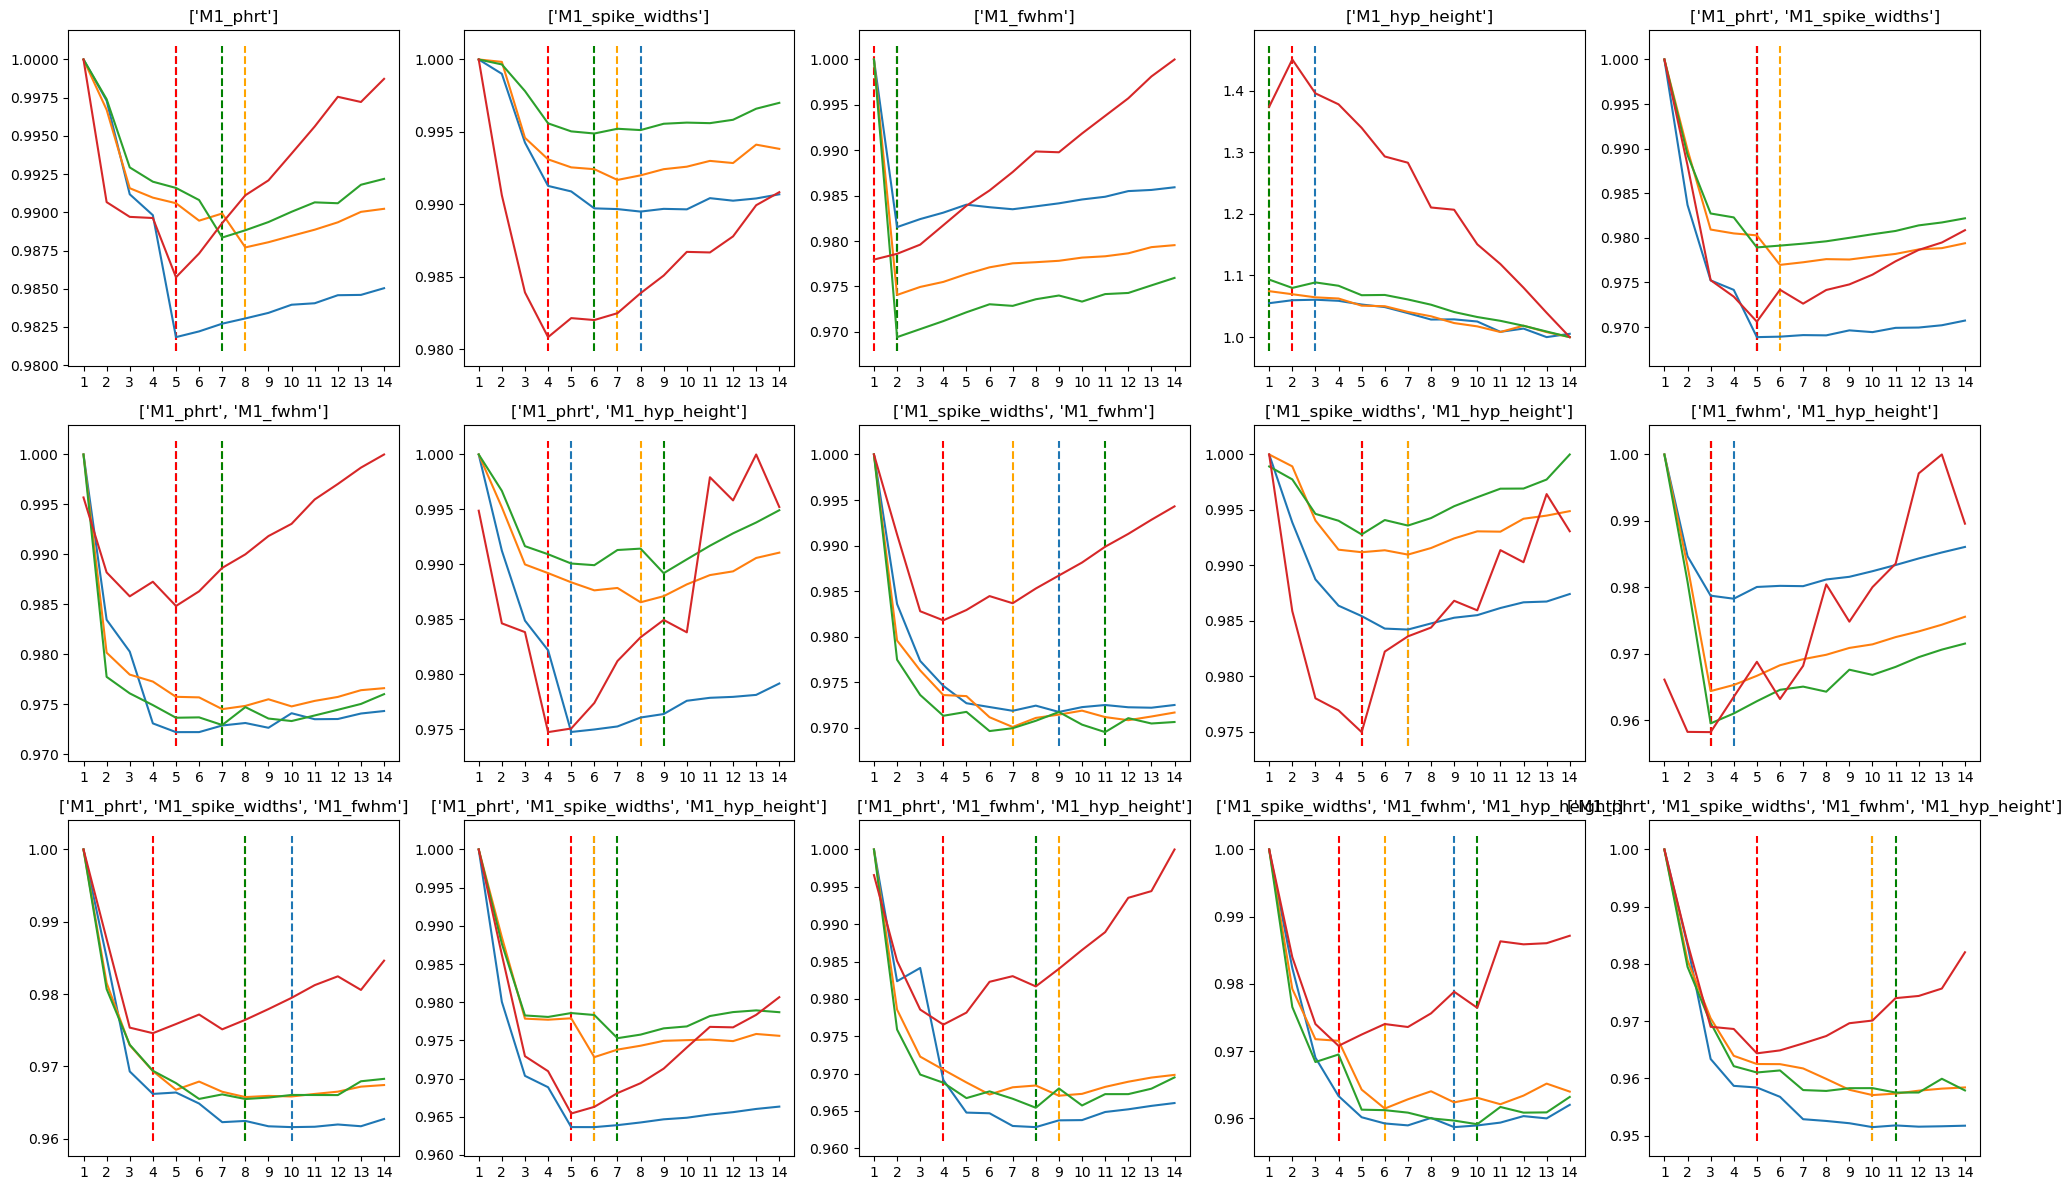

In [45]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(len(scores_all)):
    a = ax[np.unravel_index(i, (3, 5))]
    a.plot(n_components, scores_all[i]['BIC']/np.max(scores_all[i]['BIC']))
    a.plot(n_components,scores_M1[i]['BIC']/np.max(scores_M1[i]['BIC']))
    #a.plot(scores_S1[i]['BIC']/np.max(scores_S1[i]['BIC']))
    a.plot(n_components,scores_indy[i]['BIC']/np.max(scores_indy[i]['BIC']))
    a.plot(n_components,scores_loco[i]['BIC']/np.max(scores_loco[i]['BIC']))
    a.set_xticks(n_components)
    a.set_title(scores_all[i]['features'])

    ymin, ymax = a.get_ylim()
    a.vlines(np.argmin(scores_all[i]['BIC']) + 1, ymin, ymax, linestyles='dashed')
    a.vlines(np.argmin(scores_M1[i]['BIC']) + 1, ymin, ymax, linestyles='dashed', color='orange')
    a.vlines(np.argmin(scores_indy[i]['BIC']) + 1, ymin, ymax, linestyles='dashed', color='green')
    a.vlines(np.argmin(scores_loco[i]['BIC']) + 1, ymin, ymax, linestyles='dashed', color='red')

fig.tight_layout()



In [42]:
indices = []
for subset_size in range(1, 5):
    for subset in itertools.combinations(range(4), subset_size):
        indices.append(subset)

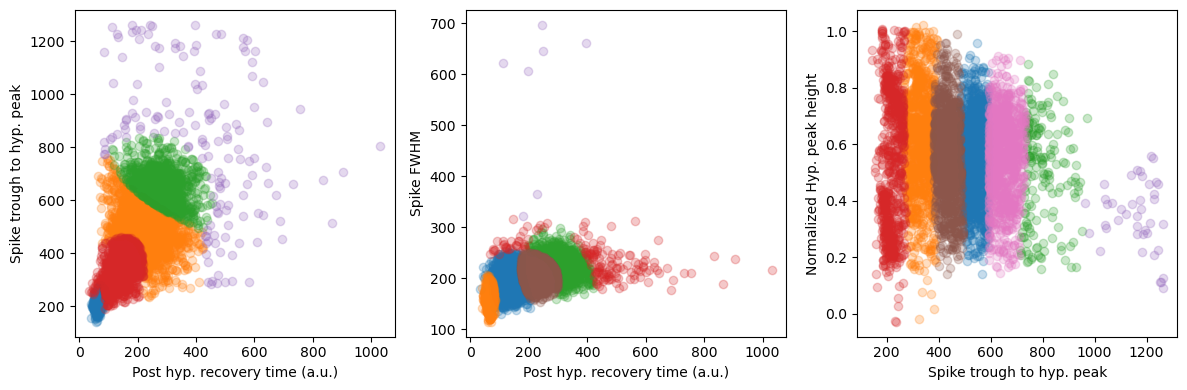

In [69]:
# Plot some of the 2D class memberships
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

prediction = scores_all[4]['BIC_model'].predict(Xall[:, indices[4]])
classes = np.unique(prediction)
for c in classes:
    ax[0].scatter(Xall[np.argwhere(prediction == c).squeeze(), indices[4][0]], Xall[np.argwhere(prediction == c).squeeze(), indices[4][1]], alpha=0.25)
ax[0].set_xlabel('Post hyp. recovery time (a.u.)')
ax[0].set_ylabel('Spike trough to hyp. peak')


prediction = scores_all[5]['BIC_model'].predict(Xall[:, indices[5]])
classes = np.unique(prediction)
for c in classes:
    ax[1].scatter(Xall[np.argwhere(prediction == c).squeeze(), indices[5][0]], Xall[np.argwhere(prediction == c).squeeze(), indices[5][1]], alpha=0.25)
ax[1].set_xlabel('Post hyp. recovery time (a.u.)')
ax[1].set_ylabel('Spike FWHM')


prediction = scores_all[8]['BIC_model'].predict(Xall[:, indices[8]])
classes = np.unique(prediction)
for c in classes:
    ax[2].scatter(Xall[np.argwhere(prediction == c).squeeze(), indices[8][0]], Xall[np.argwhere(prediction == c).squeeze(), indices[8][1]], alpha=0.25)
ax[2].set_xlabel('Spike trough to hyp. peak')
ax[2].set_ylabel('Normalized Hyp. peak height')

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/classification1.pdf', bbox_inches='tight', pad_inches=0)

In [84]:
# Need to convert units to something sensible for the time

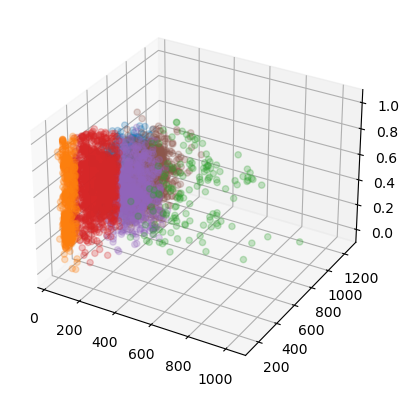

In [63]:
# Plot a 3D class membership
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


prediction = scores_all[11]['BIC_model'].predict(Xall[:, indices[11]])
classes = np.unique(prediction)
for c in classes:
    ax.scatter(Xall[np.argwhere(prediction == c).squeeze(), indices[11][0]], Xall[np.argwhere(prediction == c).squeeze(), indices[11][1]], 
                Xall[np.argwhere(prediction == c).squeeze(), indices[11][2]], alpha=0.25)


In [71]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [90]:
scores_all[4]['BIC_model'].means_

array([[231.48553085, 503.30972637],
       [271.24602397, 629.62663955],
       [148.3650466 , 351.74820108],
       [ 65.83762693, 215.04827194],
       [381.88412712, 767.86343293]])

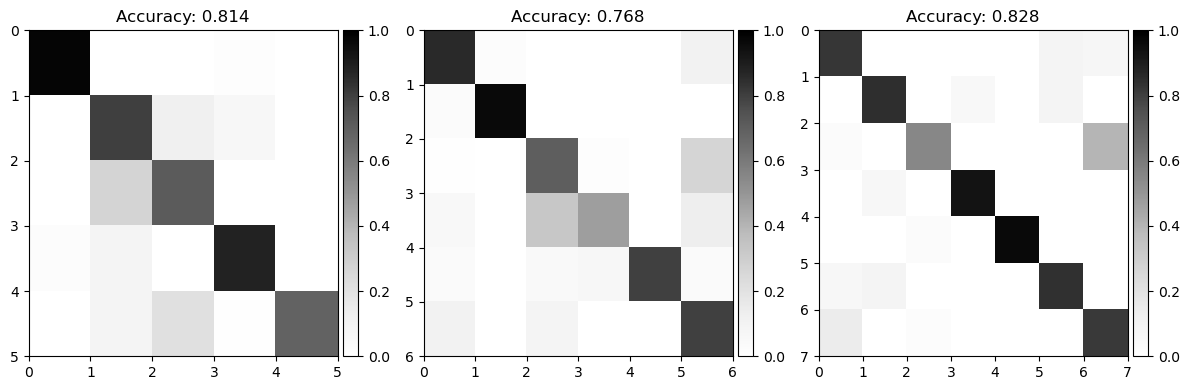

In [73]:
# Confusion matrices for the aforementioned objects
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

confusions = np.zeros((scores_all[4]['BIC_model'].n_components, scores_all[4]['BIC_model'].n_components)) 
for j, (m_, c_) in enumerate(zip(scores_all[4]['BIC_model'].means_, scores_all[4]['BIC_model'].covariances_)):
    z = np.random.multivariate_normal(mean=m_, cov=c_, size=(1000,))
    predictions = scores_all[4]['BIC_model'].predict(z)
    confusions[j, :] = [np.argwhere(predictions == k).squeeze().size/1000 for k in range(confusions.shape[1])]

im = ax[0].pcolor(confusions, cmap='Greys', vmin=0, vmax=1)
ax[0].invert_yaxis()
ax[0].set_title('Accuracy: %.3f' % np.mean(np.diag(confusions)))
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

confusions = np.zeros((scores_all[5]['BIC_model'].n_components, scores_all[5]['BIC_model'].n_components)) 
for j, (m_, c_) in enumerate(zip(scores_all[5]['BIC_model'].means_, scores_all[5]['BIC_model'].covariances_)):
    z = np.random.multivariate_normal(mean=m_, cov=c_, size=(1000,))
    predictions = scores_all[5]['BIC_model'].predict(z)
    confusions[j, :] = [np.argwhere(predictions == k).squeeze().size/1000 for k in range(confusions.shape[1])]

im = ax[1].pcolor(confusions, cmap='Greys', vmin=0, vmax=1)
ax[1].invert_yaxis()
ax[1].set_title('Accuracy: %.3f' % np.mean(np.diag(confusions)))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


confusions = np.zeros((scores_all[8]['BIC_model'].n_components, scores_all[8]['BIC_model'].n_components)) 
for j, (m_, c_) in enumerate(zip(scores_all[8]['BIC_model'].means_, scores_all[8]['BIC_model'].covariances_)):
    z = np.random.multivariate_normal(mean=m_, cov=c_, size=(1000,))
    predictions = scores_all[8]['BIC_model'].predict(z)
    confusions[j, :] = [np.argwhere(predictions == k).squeeze().size/1000 for k in range(confusions.shape[1])]

im = ax[2].pcolor(confusions, cmap='Greys', vmin=0, vmax=1)
ax[2].invert_yaxis()
ax[2].set_title('Accuracy: %.3f' % np.mean(np.diag(confusions)))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

confusions = np.zeros((scores_all[9]['BIC_model'].n_components, scores_all[9]['BIC_model'].n_components)) 
for j, (m_, c_) in enumerate(zip(scores_all[9]['BIC_model'].means_, scores_all[9]['BIC_model'].covariances_)):
    z = np.random.multivariate_normal(mean=m_, cov=c_, size=(1000,))
    predictions = scores_all[9]['BIC_model'].predict(z)
    confusions[j, :] = [np.argwhere(predictions == k).squeeze().size/1000 for k in range(confusions.shape[1])]

# im = ax[1, 1].pcolor(confusions, cmap='Greys', vmin=0, vmax=1)
# ax[1, 1].invert_yaxis()
# ax[1, 1].set_title('Accuracy: %.3f' % np.mean(np.diag(confusions)))
# divider = make_axes_locatable(ax[1, 1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/accuracy1.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Plot a 3D class membership
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


prediction = scores_all[11]['BIC_model'].predict(Xall[:, indices[11]])
classes = np.unique(prediction)
for c in classes:
    ax.scatter(Xall[np.argwhere(prediction == c).squeeze(), indices[11][0]], Xall[np.argwhere(prediction == c).squeeze(), indices[11][1]], 
                Xall[np.argwhere(prediction == c).squeeze(), indices[11][2]], alpha=0.25)


In [49]:
# In order to remove outliers, get rid of all points classified in the 5th category

n_components = np.array(np.arange(1, 15))
# Train everything together
M1_features = ['M1_phrt', 'M1_spike_widths', 'M1_fwhm', 'M1_hyp_height']
S1_features = ['S1_phrt', 'S1_spike_widths', 'S1_fwhm', 'S1_hyp_height']

# Assemble features
Xallno = []
nan_filterM1 = []
nan_filterS1 = []

for j in range(df.shape[0]):
    
    x = []
    for feature in M1_features:
        xx = df.iloc[j][feature]           
        # Workaround for fwhm...
        xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]

        x.append(np.array(xx).squeeze()[..., np.newaxis])

    x = np.hstack(x)
    Xallno.extend(x)

    # M1 only
    valid_wf_idxs = np.arange(x.shape[0])
    for k in range(x.shape[1]):
        valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(x[valid_wf_idxs, k]))]

    # Remove 5th category neurons
    xfilt = x[valid_wf_idxs]
    xfilt = xfilt[:, indices[4]]
    yy = scores_all[4]['BIC_model'].predict(xfilt)
    noncat5idxs = np.argwhere(yy != 4).squeeze()
    nan_filterM1.append({'data_file':df.iloc[j]['data_file'], 'valid_idxs':valid_wf_idxs[noncat5idxs]})

    # S1 features, if present
    if np.any(np.invert(np.isnan(df.iloc[j][S1_features[0]]))):
        x = []
        for feature in S1_features:
            xx = df.iloc[j][feature]           
            # Workaround for fwhm...
            xx = [elem[0] if not np.isscalar(elem) else elem for elem in xx]

            x.append(np.array(xx).squeeze()[..., np.newaxis])

        x = np.hstack(x)
        Xallno.extend(x)

# Remove nans
Xallno = np.array(Xallno)

valid_wf_idxs = np.arange(Xallno.shape[0])
for j in range(Xallno.shape[1]):
    valid_wf_idxs = valid_wf_idxs[np.invert(np.isnan(Xallno[valid_wf_idxs, j]))]

Xallno = Xallno[valid_wf_idxs]
for j in range(Xallno.shape[1]):
    assert(np.all(np.invert(np.isnan(Xallno[:, j]))))


# Remove outliers
nonoutlier_idxs = np.argwhere(scores_all[4]['BIC_model'].predict(Xallno[:, indices[4]]) != 4).squeeze()
Xallno = Xallno[nonoutlier_idxs]

scores_allno = []
for subset_size in range(1, 5):
    for subset in itertools.combinations(range(4), subset_size):
        r = {}
        r['features'] = [M1_features[idx] for idx in subset]

        AIC = np.zeros(n_components.size)
        BIC = np.zeros(n_components.size)
        models = []
        for i, nc in enumerate(n_components):
            mm_model = GaussianMixture(n_components=nc)
            mm_model.fit(Xallno[:, subset])
            AIC[i] = mm_model.aic(Xallno[:, subset])
            BIC[i] = mm_model.bic(Xallno[:, subset])
            models.append(mm_model)

        r['AIC'] = AIC
        r['BIC'] = BIC
        r['BIC_model'] = models[np.argmin(BIC)]
        scores_allno.append(r)

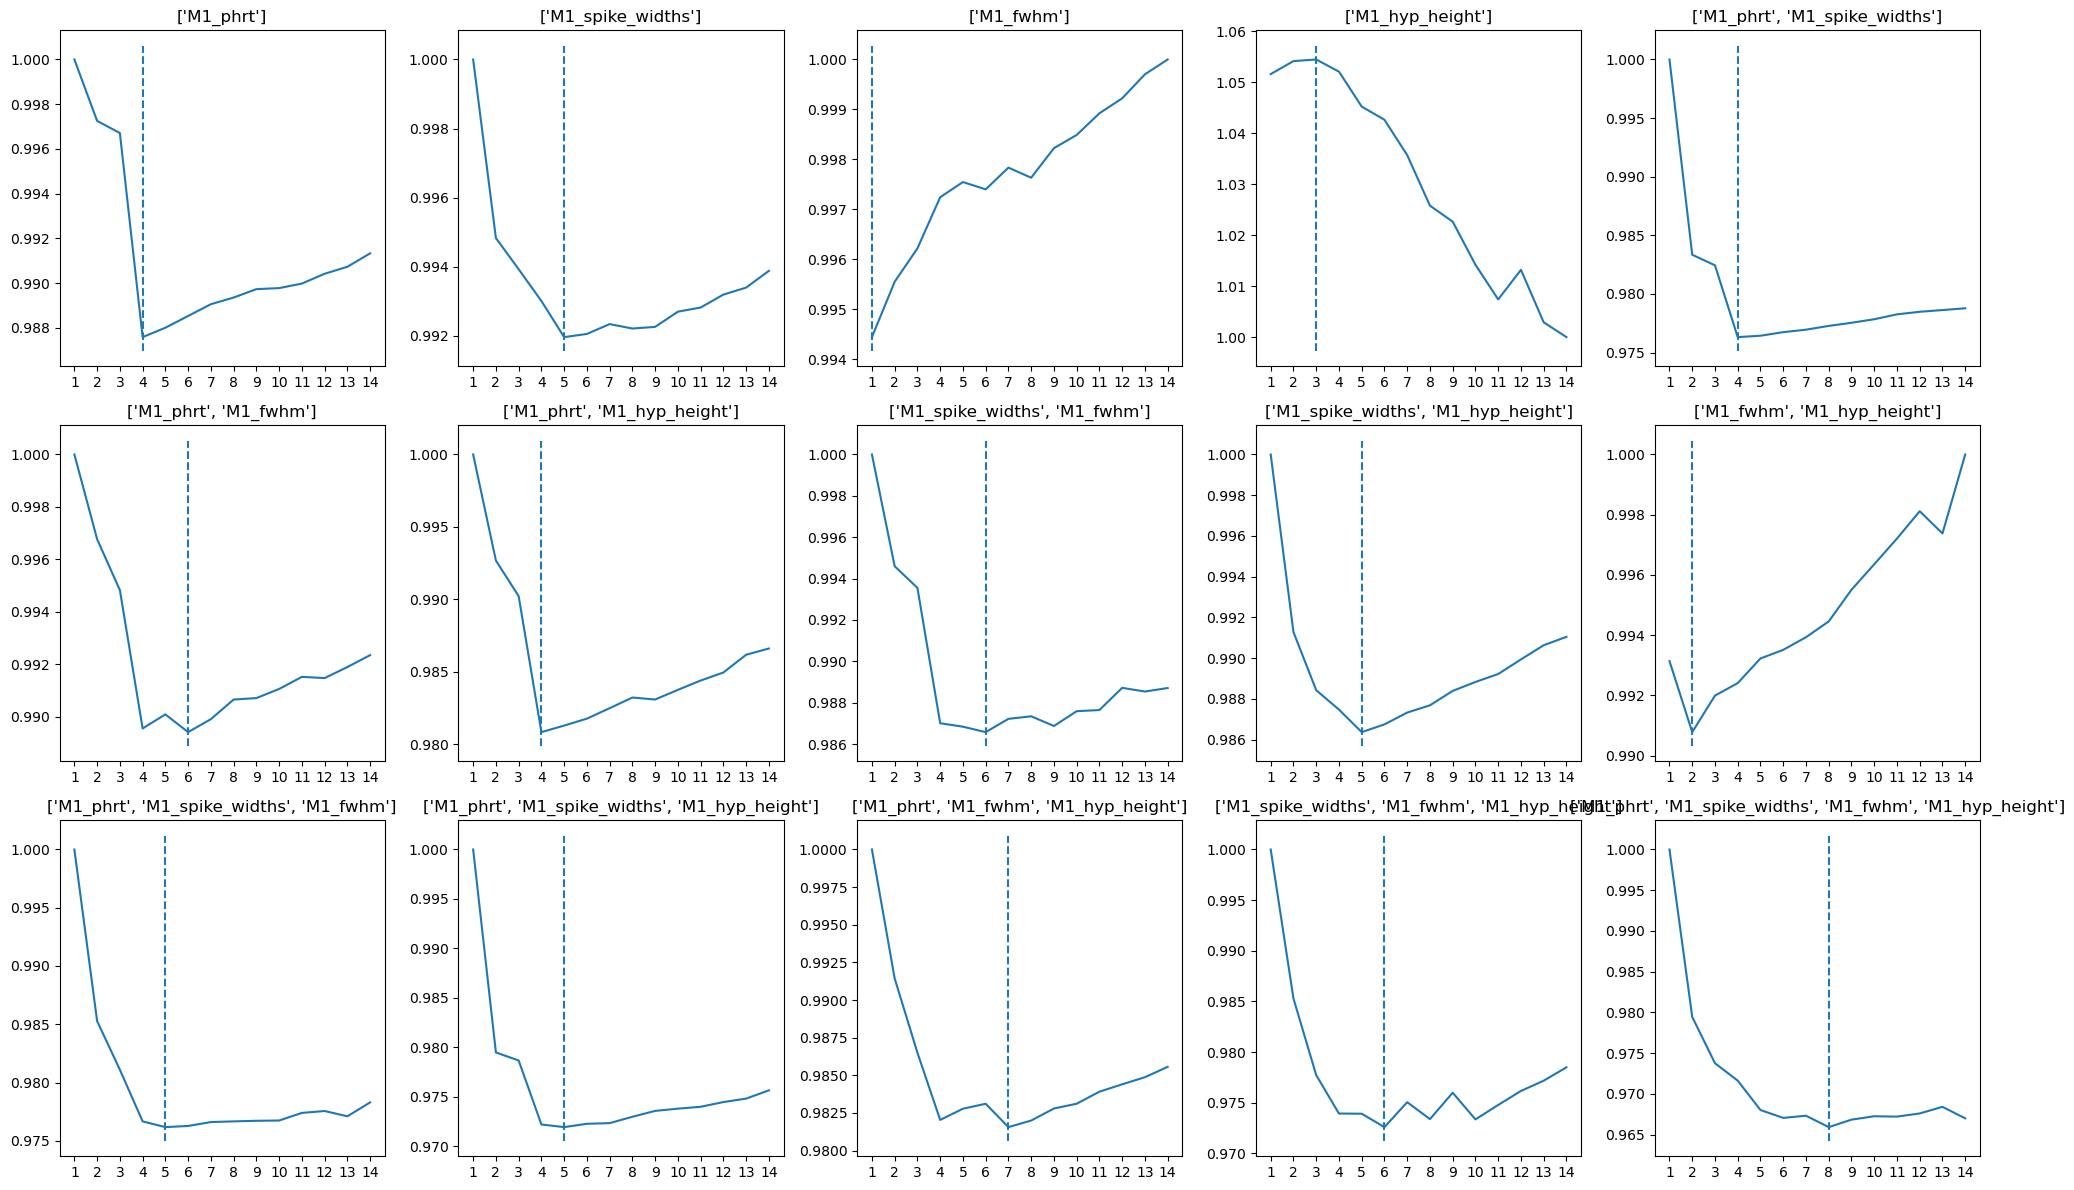

In [93]:
# What is the new BIC curve, the new assignment, and the new confusion matrix?
fig, ax = plt.subplots(3, 5, figsize=(20, 12))
for i in range(len(scores_all)):
    a = ax[np.unravel_index(i, (3, 5))]
    a.plot(n_components, scores_allno[i]['BIC']/np.max(scores_allno[i]['BIC']))
    a.set_xticks(n_components)
    a.set_title(scores_all[i]['features'])

    ymin, ymax = a.get_ylim()
    a.vlines(np.argmin(scores_allno[i]['BIC']) + 1, ymin, ymax, linestyles='dashed')

fig.tight_layout()



/tmp/ipykernel_24665/174129690.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/classification2.pdf', bbox_inches='tight', pad_inhces=0)


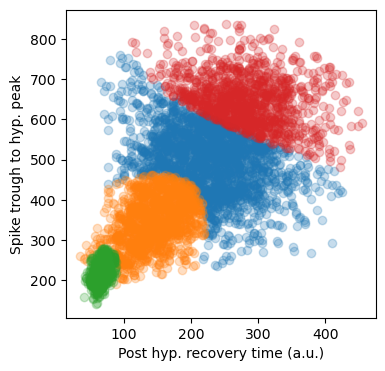

In [75]:
# Plot some of the 2D class memberships
fig, ax = plt.subplots(figsize=(4, 4))

prediction = scores_allno[4]['BIC_model'].predict(Xallno[:, indices[4]])
classes = np.unique(prediction)
for c in classes:
    ax.scatter(Xallno[np.argwhere(prediction == c).squeeze(), indices[4][0]], Xallno[np.argwhere(prediction == c).squeeze(), indices[4][1]], alpha=0.25)
ax.set_xlabel('Post hyp. recovery time (a.u.)')
ax.set_ylabel('Spike trough to hyp. peak')
fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/classification2.pdf', bbox_inches='tight', pad_inhces=0)

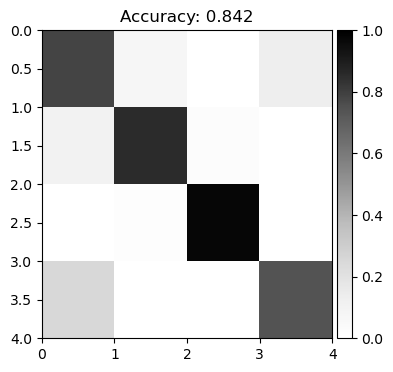

In [76]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))

confusions = np.zeros((scores_allno[4]['BIC_model'].n_components, scores_allno[4]['BIC_model'].n_components)) 
for j, (m_, c_) in enumerate(zip(scores_allno[4]['BIC_model'].means_, scores_allno[4]['BIC_model'].covariances_)):
    z = np.random.multivariate_normal(mean=m_, cov=c_, size=(1000,))
    predictions = scores_allno[4]['BIC_model'].predict(z)
    confusions[j, :] = [np.argwhere(predictions == k).squeeze().size/1000 for k in range(confusions.shape[1])]

im = ax.pcolor(confusions, cmap='Greys', vmin=0, vmax=1)
ax.invert_yaxis()
ax.set_title('Accuracy: %.3f' % np.mean(np.diag(confusions)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/accuracy2.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Restrict to M1 (?)

In [ ]:
# Tasks
# (1) Visualization of classes, as poor as they may be
# (2) Take a look at outliers, are we filtering things out corectly
# (3) Similarity between raw broadband and wf classification 
# (4) UMAP visualization
# (5) Correlation with loadings: There might be rank correlations even if we cannot establish categories

In [50]:
nan_filterM1 = pd.DataFrame(nan_filterM1)

In [10]:
# Get loadings
#dframe = '/home/akumar/nse/neural_control/data/indy_decoding_marginal.dat'
dframe_indy = '/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat'
dframe_loco = '/mnt/Secondary/data/postprocessed/loco_decoding_df.dat'

print('Using dframes %s, %s' % (dframe_indy, dframe_loco))

with open(dframe_indy, 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open(dframe_loco, 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

DIM = 6

Using dframes /mnt/Secondary/data/postprocessed/indy_decoding_df2.dat, /mnt/Secondary/data/postprocessed/loco_decoding_df.dat


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-lear

In [32]:
np.array(df.iloc[0]['M1_spike_widths']).shape

(129,)

In [51]:

# Try the raw leverage scores instead
loadings_l = []
indy_data_files = np.unique(indy_df['data_file'].values)
for i in tqdm(range(df.shape[0])):
    data_file = df.iloc[i]['data_file']
    loadings = []

    # Apply the appropriate filter
    nf = apply_df_filters(nan_filterM1, data_file=data_file.split('.mat')[0])
    try:
        assert(nf.shape[0] == 1)
    except:
        pdb.set_trace()


    for dimreduc_method in ['LQGCA', 'PCA']:
        loadings_fold = []
        for fold_idx in range(5):  
            if 'indy' in df.iloc[i]['data_file']:
                df_ = apply_df_filters(indy_df, data_file='%s.mat' % data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)
            else:
                df_ = apply_df_filters(loco_df, data_file='%s.mat' % data_file, fold_idx=fold_idx, dim=DIM, dimreduc_method=dimreduc_method)

            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        


            V = V[nf.iloc[0]['valid_idxs'], :]
            loadings_fold.append(calc_loadings(V))


        # Average loadings across folds
        loadings.append(np.mean(np.array(loadings_fold), axis=0))

    d_ = {}
    d_['data_file'] = data_file
    d_['FCCA_loadings'] = loadings[0]
    d_['PCA_loadings'] = loadings[1]
    # d_['DCA_loadings'] = loadings[2][j]
    # Grab the relevant features


    d_['M1_sw'] = np.array(df.iloc[i]['M1_spike_widths'])[nf.iloc[0]['valid_idxs']]
    d_['M1_phrt'] = np.array(df.iloc[i]['M1_phrt'])[nf.iloc[0]['valid_idxs']]

    loadings_l.append(d_)                

loadings_df = pd.DataFrame(loadings_l)

100%|██████████| 35/35 [00:00<00:00, 41.54it/s]


In [52]:
sum([loadings_df.iloc[k]['FCCA_loadings'].size for k in range(loadings_df.shape[0])])

4282

In [53]:
sum([loadings_df.iloc[k]['M1_sw'].size for k in range(loadings_df.shape[0])])

4282

In [64]:
%matplotlib inline

/tmp/ipykernel_24665/1605822200.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


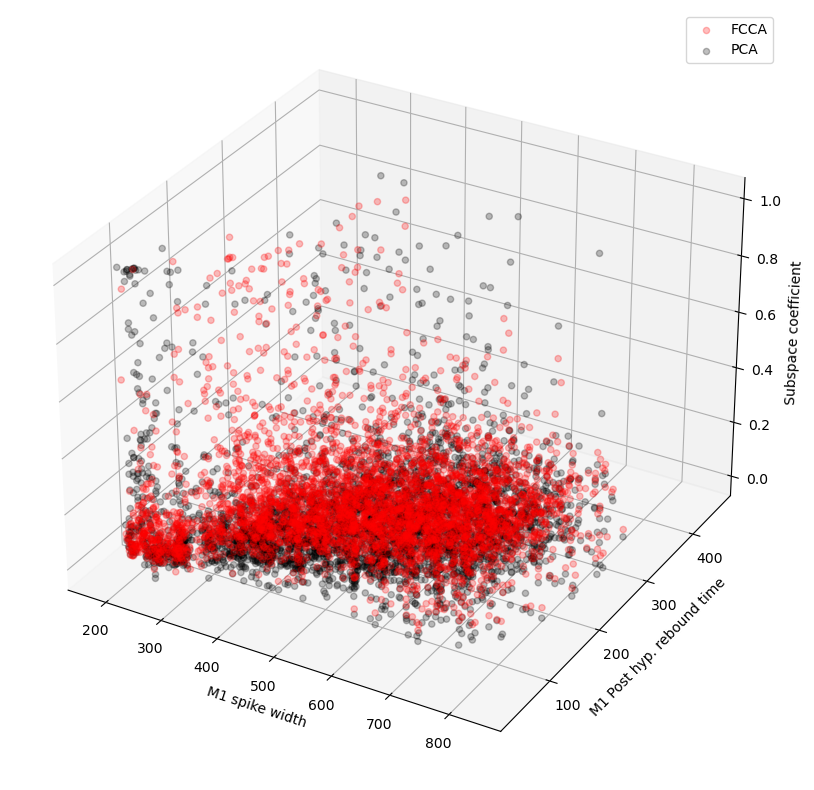

In [78]:
# Plot a 3D class membership
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

x = []
y = []
z1 = []
z2 = []
for k in range(loadings_df.shape[0]):
    x.extend(loadings_df.iloc[k]['M1_sw'])
    y.extend(loadings_df.iloc[k]['M1_phrt'])
    z1.extend(loadings_df.iloc[k]['FCCA_loadings'])
    z2.extend(loadings_df.iloc[k]['PCA_loadings'])

ax.scatter(x, y, z1, alpha=0.25, color='r')
ax.scatter(x, y, z2, alpha=0.25, color='k')
ax.set_xlabel('M1 spike width')
ax.set_ylabel('M1 Post hyp. rebound time')
ax.set_zlabel('Subspace coefficient')

ax.legend(['FCCA', 'PCA'])

fig.show()
fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/loadings1.pdf', bbox_inches='tight', pad_inches=0)
# classes = np.unique(prediction)
# for c in classes:
#     ax.scatter(Xall[np.argwhere(prediction == c).squeeze(), indices[11][0]], Xall[np.argwhere(prediction == c).squeeze(), indices[11][1]], 
#                 Xall[np.argwhere(prediction == c).squeeze(), indices[11][2]], alpha=0.25)


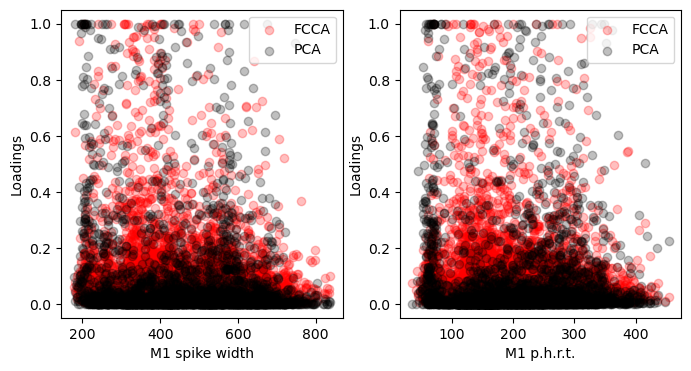

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].scatter(x, z1, color='r', alpha=0.25)
ax[0].scatter(x, z2, color='k', alpha=0.25)

ax[1].scatter(y, z1, color='r', alpha=0.25)
ax[1].scatter(y, z2, color='k', alpha=0.25)
ax[0].set_xlabel('M1 spike width')
ax[0].set_ylabel('Loadings')
ax[0].legend(['FCCA', 'PCA'])

ax[1].set_xlabel('M1 p.h.r.t.')
ax[1].set_ylabel('Loadings')
ax[1].legend(['FCCA', 'PCA'])

fig.savefig('/home/akumar/nse/neural_control/figs/spikeclass/loadings2.pdf', bbox_inches='tight', pad_inches=0)